#Matthew Joel
#Linear Spline Interpolation


The distinguishing feature of *adaptive approximation* is that the domain of the function is repeatedly subdivided in order to obtain more accurate approximations on smaller subdomains. The resulting global approximation will then be defined piecewise by patching together many local approximations. It is clear that spline functions with free knots are well suited for this type of approximation.


**Algorithm**
1. input $a, b, \varepsilon, M$
2. $t_0 \leftarrow a ; t_1 \leftarrow b ; y_0 \leftarrow f\left(t_0\right) ; y_1 \leftarrow f\left(t_1\right)$
3. call MAX $\left(f, t_0, t_1, c_1, d_1\right)$
4. for $n=1,2, \ldots, M-1$ do
    1. $\quad$Select $i$ so that $d_i$ = max($\{d_1, d_2, \ldots, d_n\}$).
    2. $\quad$ if $d_i \leq \varepsilon$ exit loop
    3. $\quad$ for $j=n, n-1, \ldots, i+1$ do
        1. $t_{j+1} \leftarrow t_j$
        2. $\quad y_{j+1} \leftarrow y_j$
        3. $\quad d_{j+1} \leftarrow d_j$
        4. $\quad c_{j+1} \leftarrow c_j$
    4. end
    5. $t_{i+1} \leftarrow t_i$
    6. $y_{i+1} \leftarrow y_i$
    7. $t_i \leftarrow c_i$
    8. $y_i \leftarrow f\left(c_i\right)$
    9. call MAX $\left(f, t_{i-1}, t_i, c_i, d_i\right)$
    10. call MAX $\left(f, t_i, t_{i+1}, c_{i+1}, d_{i+1}\right)$
5. end
6. output $n,\left(t_0, t_1, \ldots, t_n\right),\left(y_0, y_1, \ldots, y_n\right),\left(d_1, d_2, \ldots, d_n\right)$

The algorithm starts with just two knots, $t_0=a$ and $t_1=b$. Next, there is a determination of the maximum deviation $d_1$ on the interval $\left[t_0, t_1\right]$. If $d_1$ is larger than the allowable tolerance $\varepsilon$, then the point $c_1$ where the maximum deviation occurred becomes a knot. The knot $t_1$ is relabeled $t_2$, and $c_1$ becomes $t_1$. The maximum deviations are then computed on $\left[t_0, t_1\right]$ and $\left[t_1, t_2\right]$. If either exceeds $\varepsilon$, the process is continued. Eventually either all deviations fall below $\varepsilon$ (success) or the upper limit on the number of steps $(M)$ is exceeded (failure). Enough storage must be provided to allow $M$ components in the arrays $t, y, d$, and $c$.

In this algorithm, there appear three references to a subroutine or procedure MAX. The purpose of
$$
\operatorname{MAX}(f, \alpha, \beta, c, d)
$$
is to compute the maximum of
$$
|f(x)-\ell(f, \alpha, \beta ; x)|
$$
on the interval $[\alpha, \beta]$, storing the maximum value in $d$ and storing the appropriate point at which this occurs in $c$. In practice, the values of $c$ and $d$ need not be computed to high precision. A rough way to do this is to sample the values of $|f(x)-\ell(f, \alpha, \beta ; x)|$ at, say, fifteen points across the interval, and to accept one of these as the desired point. Here is an algorithm to do just this.

1. procedure MAX $(f, \alpha, \beta, c, d)$
2. $k \leftarrow 14$
3. $h \leftarrow(\beta-\alpha) / k$
4. for $i=0,1, \ldots, k$ do
    1. $z_i \leftarrow f(\alpha+i h)$
5. end
6. for $i=1,2, \ldots, k-1$ do
    1. $z_i \leftarrow\left|z_i-\left(i z_k+(k-i) z_0\right) / k\right|$
7. end
8. $d \leftarrow 0$
9. for $i=1,2, \ldots, k-1$ do
    1. if $z_i>d$ then
        1. $\quad d \leftarrow z_i$
        2. $\quad c \leftarrow \alpha+i h$
    2. end if
10. end
11. return

**MAX Finding**

Suppose a computer program incorporating the adaptive approximation method described above was tested using the function $f(x)=\sqrt{x}$ on the interval $[0,1]$ and with $\varepsilon=10^{-3}$. Below is the function which finds the largest splines.



In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def MAX_LinSpline(f, le, re):
    """
    Compute the maximum of |f(x)-l(f,le,re;x)| on the interval [le,re],
    where l is a linear function that passes (le, f(le)) and (re, f(re)).
    Here, use ELEVEN points equally spaced between le and re (both inluded)
    to find the maximum
    input:
    f: func, the function to be approximated
    le: float, the left end of interval
    re: float, the right end of interval
    return:
    c: float, where the maximum occurs
    d: float, the maximum
    """
    k = 10
    h = (re - le) / k
    z = [f(le + i * h) for i in range(k+1)]

    for i in range(1, k-1):
        z[i] = abs(z[i] - ((i * z[k]) + ((k - i) * z[0])) / k)

    d = 0
    c=0
    for i in range(1, k-1):
        if z[i] > d:
            d = z[i]
            c = le + i * h

    return c, d

**Adaptive Spline** Now that we have our MAX function, let's finally build our spline function.

In [10]:
def Adaptive_LinSpline(f, a, b, eps, M):
  """
  Perform adaptive linear spline approximation
  input:
    f: func, the function to be approximated
    a: float, left end of the entire interval
    b: float, right end of the entire interval
    eps: float, the tolerance for the stopping criterion
    M: int, perform at most M steps of the algorithm (another stopping criterion)
  return:
    n: int, the number of steps run
    t: 1d numpy array, the knots
    y: 1d numpy array, the function value evaluated at the knots t
    d: 1d numpy array, the collection of maximum absolute difference on each subinterval
  """
  # I used lists (instead of a np.array of M length) since they are variable length (mutable).
  t = list()
  t.append(a)
  t.append(b)

  y = list()
  y.append(f(a))
  y.append(f(b))

  d = list()
  c = list()

  c_,d_ = MAX_LinSpline(f,t[0],t[1])
  c.append(c_)
  d.append(d_)


  for n in range(1,M-1,1):
    i = d.index(max(d))
    if d[i] <= eps:

      break

    for j in range(n-1, i + 1, -1):
      t.append(t[j])
      y.append(y[j])
      d.append(d[j])
      c.append(c[j])



    t.append(t[i])
    y.append(f(t[i]))
    t[i] = c[i]
    y[i] = f(c[i])
    c[i], d[i] = MAX_LinSpline(f, t[i - 1], t[i])
    c2,d2 = MAX_LinSpline(f, t[i], t[i + 1])
    c.append(c2)
    d.append(d2)

  return n, t, y, d


Let's now approximate the problem ($f(x)=\sqrt{x}$) discussed above. To do this, we should:
1. Print out all the knots.
2. Make a plot of the knots.
3. Make a plot of the adaptive linear spline along with the original function over $[0, 1]$.

In [11]:
def f(x):
    return np.sqrt(x)
a = 0
b = 1
eps = 1e-3
M = 5 #not sure which M to choose
n, t, y, d = Adaptive_LinSpline(f, a, b, eps, M)

In [12]:
#1.
def printKnots (t,y):
  for i in range(0,len(t),1):
    print ("Knot",i,": (",t[i],",",y[i],")")
    if i!=len(t)-1:
      print("d=",d[i])

printKnots (t,y)

Knot 0 : ( 0.09000000000000002 , 0.30000000000000004 )
d= 0.018044049290217745
Knot 1 : ( 1 , 1.0 )
d= 0.03294377608329124
Knot 2 : ( 0.454 , 0.6737952211169207 )
d= 0.01574533933322797
Knot 3 : ( 0.30000000000000004 , 0.5477225575051662 )
d= 0.0032443680093067195
Knot 4 : ( 0 , 0.0 )


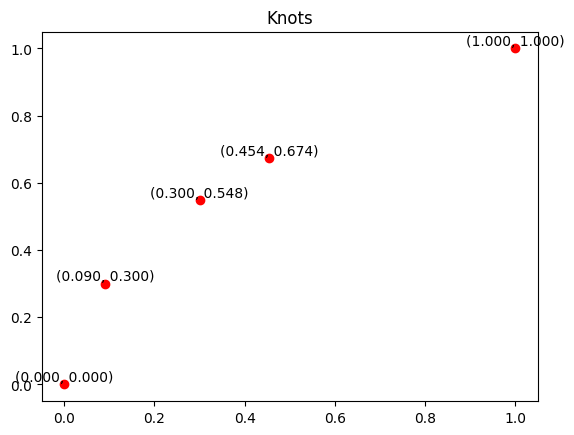

In [13]:
#2.
plt.scatter(t, y, color='red', label='Knots')
plt.title('Knots')
for i in range(len(t)):
    plt.text(t[i], y[i], f'({t[i]:.3f}, {y[i]:.3f})', ha='center', va='bottom')


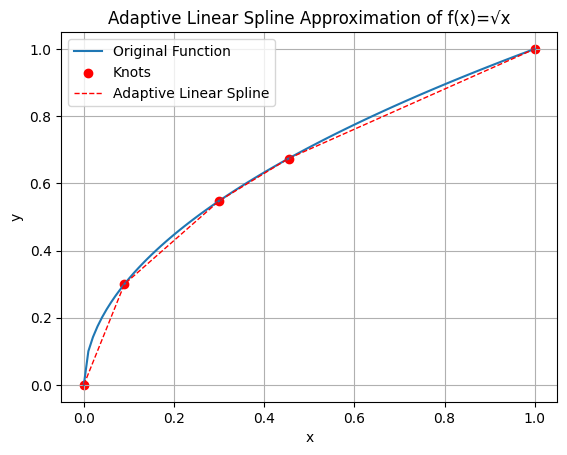

In [14]:
#3.
x_vals = np.linspace(a, b, 100)
y_vals = f(x_vals)
plt.plot(x_vals, y_vals, label='Original Function')

data = list(zip(t, y))
sorted_data = sorted(data, key=lambda point: point[0])
sorted_t, sorted_y = zip(*sorted_data)
plt.scatter(sorted_t, sorted_y, color='red', label='Knots')
plt.plot(sorted_t, sorted_y, color='red', label = 'Adaptive Linear Spline', linestyle='dashed', linewidth=1, markersize=6)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Adaptive Linear Spline Approximation of f(x)=√x')
plt.legend()
plt.grid(True)
plt.show()